# Multi-Armed Bandits

## Bandit machines

- Bandit machines used in casinos which have one lever
- The player needs to push the lever to win a jackpot or loose all their money
- The nature of the machine to get the players to empty their pockets is the reason it is called bandit machine.

Let's say a bandit machines has n arms you can choose from, each with a static probability of winning you the jackpot.

## Action Value Methods

The true value of an action is the mean reward of when we select such action.

$$q_*(a)=\mathbb{E}[R_t|A_t=a]$$
$$Q_t(a) = \frac{\sum_{i=1}^{N_t(a)} R_i}{N_t(a)}

### Epsilon Greedy Action Selection: 
$$A_t = \argmax_a Q_t(a) \text{ with probability 1-}\epsilon$$
### Upper Confidence Bound Action Selection:
$$ A_t = \argmax_a \left[Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}}\right] $$

### Incremental Update Implementation

We test different approaches:
- True greedy (epsilon = 0)
- Epsilon-Greedy (epsilon = 0.01 and 0.1)
- Optimistic Initial Value approach (epsilon = 0, 0.01, 0.1)
- UCB
- Optimistic UCB

/tmp/ipykernel_392486/800435747.py:20: RuntimeWarning: invalid value encountered in divide
  ucb_values = q_a + c * np.sqrt(np.log(t + 1) / n_a)


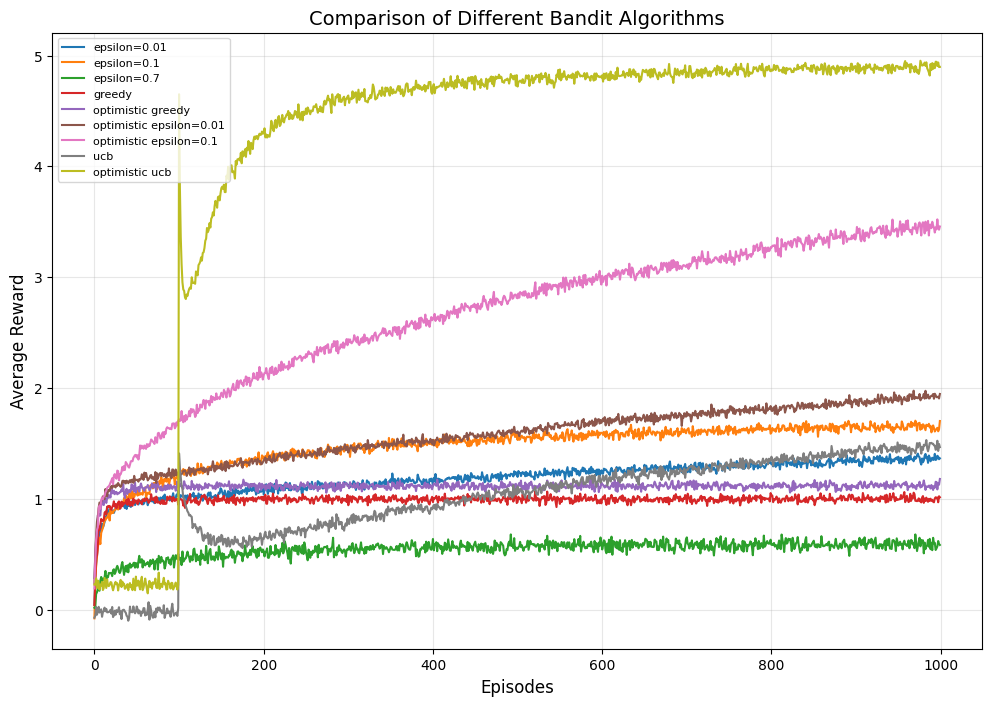

In [23]:
import numpy as np
import matplotlib.pyplot as plt

n = 100
q_star = np.random.normal(0, 1, n) # true action-value function
q_star_optimistic = np.random.normal(0, 1, n)
q_star_optimistic[0] = 5 # optimistic initialization

def argmax(q_a):
    q_a = np.array(q_a)
    max_indices = np.argwhere(q_a == np.max(q_a)).flatten()
    if len(max_indices) == 1:
        return max_indices[0]
    else:
        return np.random.choice(max_indices) # break ties randomly
    
def ucb_action_selection(q_a, n_a, t, c=2.0):
    # For actions that haven't been selected yet, set high UCB value
    with np.errstate(divide='ignore'):
        ucb_values = q_a + c * np.sqrt(np.log(t + 1) / n_a)
    
    # Set actions with zero count to have a very high value to ensure they're selected first
    ucb_values[n_a == 0] = np.inf
    
    return argmax(ucb_values)

def bandit(a,q_star_a):
    # Simulate the reward of the action a
    # with respect to the true action-value function q_star_a
    # and return the reward
    reward = np.random.normal(q_star_a[a], 1)
    return reward

def epsilon_greedy(q_a, epsilon):
    # Select action a according to the epsilon-greedy policy
    # with respect to the action-value function q_a
    if np.random.rand() < epsilon:
        return np.random.randint(len(q_a)) # explore
    else:
        return argmax(q_a) # exploit

def run_experiment_once(n, epsilon, n_episodes, q_star=q_star, method='epsilon-greedy'):
    q_a = np.zeros(n)
    n_a = np.zeros(n)
    n_a_steps = np.zeros((n_episodes, n))
    q_a_steps = np.zeros((n_episodes, n))
    r_steps = np.zeros(n_episodes)
    a_steps = np.zeros(n_episodes)
    rewards = np.zeros(n_episodes)

    for episode in range(n_episodes):
        if method == 'epsilon-greedy':
            # Select action a according to the epsilon-greedy policy
            a = epsilon_greedy(q_a, epsilon)
        elif method == 'ucb':
            # Select action a according to the UCB policy
            a = ucb_action_selection(q_a, n_a, episode)
        # Simulate the reward of the action a
        r = bandit(a, q_star)
        # Update action count
        n_a[a] += 1
        # Update action-value function estimate
        q_a[a] += (r - q_a[a]) / n_a[a]
        # Store reward
        rewards[episode] = r
        
        a_steps[episode] = a
        n_a_steps[episode] = n_a.copy()
        q_a_steps[episode] = q_a.copy()
        r_steps[episode] = r

    return n_a_steps, q_a_steps, r_steps, a_steps

def run_experiment(n_runs=2000,n_episodes=1000,eps=0.01, q_star=q_star, method='epsilon-greedy'):
    n_a_runs = []
    q_a_runs = []
    r_a_runs = []
    a_steps_runs = []
    for run in range(n_runs):
        n_a,q_a,r_a,a_steps = run_experiment_once(n=n,epsilon=eps,n_episodes=n_episodes, q_star=q_star, method=method)
            
        n_a_runs.append(n_a.copy())
        q_a_runs.append(q_a.copy())
        r_a_runs.append(r_a.copy())
        a_steps_runs.append(a_steps.copy())
    
    r_values= np.array(r_a_runs)
    avg_rewards = r_values.mean(axis=0)
    n_a_values = np.array(n_a_runs)
    avg_n_a = n_a_values.mean(axis=0)
    q_a_values = np.array(q_a_runs)
    avg_q_a = q_a_values.mean(axis=0)
    a_steps_values = np.array(a_steps_runs)
    avg_a_steps = a_steps_values.mean(axis=0)
    
    return avg_rewards, avg_n_a, avg_q_a, avg_a_steps

def main():
    n_episodes = 1000
    plt.figure(figsize=(12, 8))
    
    rewards, n_a, q_a, a_steps = run_experiment(n_episodes=n_episodes, eps=0.01)
    plt.plot(rewards, label=f'epsilon=0.01')
    
    rewards, n_a, q_a, a_steps = run_experiment(n_episodes=n_episodes, eps=0.1)
    plt.plot(rewards, label=f'epsilon=0.1')

    rewards, n_a, q_a, a_steps = run_experiment(n_episodes=n_episodes, eps=0.7)
    plt.plot(rewards, label=f'epsilon=0.7')
    
    rewards, n_a, q_a, a_steps = run_experiment(n_episodes=n_episodes, eps=0.0)
    plt.plot(rewards, label=f'greedy')
    
    rewards, n_a, q_a, a_steps = run_experiment(n_episodes=n_episodes, eps=0.0, q_star=q_star_optimistic)
    plt.plot(rewards, label=f'optimistic greedy')
    
    rewards, n_a, q_a, a_steps = run_experiment(n_episodes=n_episodes, eps=0.01, q_star=q_star_optimistic)
    plt.plot(rewards, label=f'optimistic epsilon=0.01')
    
    rewards, n_a, q_a, a_steps = run_experiment(n_episodes=n_episodes, eps=0.1, q_star=q_star_optimistic)
    plt.plot(rewards, label=f'optimistic epsilon=0.1')
    
    rewards, n_a, q_a, a_steps = run_experiment(n_episodes=n_episodes, eps=0.0, method='ucb')
    plt.plot(rewards, label=f'ucb')
    
    rewards, n_a, q_a, a_steps = run_experiment(n_episodes=n_episodes, eps=0.0, q_star=q_star_optimistic, method='ucb')
    plt.plot(rewards, label=f'optimistic ucb')
    
    plt.legend(prop={'size': 8})
    plt.xlabel('Episodes', fontsize=12)
    plt.ylabel('Average Reward', fontsize=12)
    plt.title('Comparison of Different Bandit Algorithms', fontsize=14)
    plt.grid(alpha=0.3)

main()

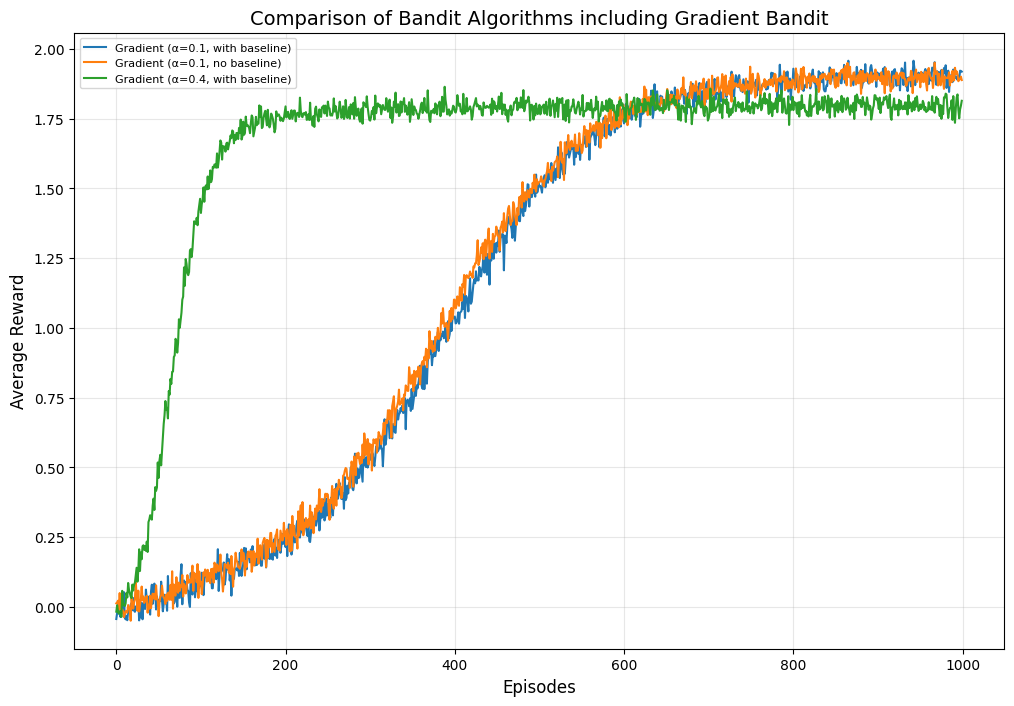

In [21]:
def softmax(preferences):
    """Compute softmax probabilities from preferences"""
    exp_pref = np.exp(preferences - np.max(preferences))  # Subtract max for numerical stability
    return exp_pref / np.sum(exp_pref)

def gradient_bandit_action_selection(preferences):
    """Select an action based on softmax probabilities"""
    probs = softmax(preferences)
    return np.random.choice(len(preferences), p=probs), probs

def run_gradient_bandit_experiment_once(n, alpha, n_episodes, q_star, use_baseline=True):
    """Run one experiment of gradient bandit algorithm"""
    # Initialize preferences to zeros
    preferences = np.zeros(n)
    
    # Initialize variables for tracking
    rewards = np.zeros(n_episodes)
    avg_reward = 0  # Baseline (average reward)
    
    for episode in range(n_episodes):
        # Select action using softmax probabilities
        action, probs = gradient_bandit_action_selection(preferences)
        
        # Get reward for selected action
        reward = bandit(action, q_star)
        
        # Update baseline (average reward)
        avg_reward += (reward - avg_reward) / (episode + 1)
        
        # Store reward
        rewards[episode] = reward
        
        # For the update, we use the baseline if specified, otherwise use 0
        baseline = avg_reward if use_baseline else 0
        
        # Update preferences using the gradient bandit update rule
        for a in range(n):
            if a == action:
                preferences[a] += alpha * (reward - baseline) * (1 - probs[a])
            else:
                preferences[a] -= alpha * (reward - baseline) * probs[a]
    
    return rewards

def run_gradient_bandit_experiment(n_runs=2000, n_episodes=1000, alpha=0.1, q_star=q_star, use_baseline=True):
    """Run multiple experiments and average results"""
    all_rewards = np.zeros((n_runs, n_episodes))
    
    for run in range(n_runs):
        rewards = run_gradient_bandit_experiment_once(n, alpha, n_episodes, q_star, use_baseline)
        all_rewards[run] = rewards
    
    # Average rewards across all runs
    avg_rewards = np.mean(all_rewards, axis=0)
    return avg_rewards

# Set the number of episodes
n_episodes = 1000

# Test the gradient bandit algorithm
rewards_gradient_with_baseline = run_gradient_bandit_experiment(n_episodes=n_episodes, alpha=0.1, use_baseline=True)
rewards_gradient_without_baseline = run_gradient_bandit_experiment(n_episodes=n_episodes, alpha=0.1, use_baseline=False)
rewards_gradient_higher_alpha = run_gradient_bandit_experiment(n_episodes=n_episodes, alpha=0.4, use_baseline=True)

# Plot results
plt.figure(figsize=(12, 8))

# Add new gradient bandit results
plt.plot(rewards_gradient_with_baseline, label='Gradient (α=0.1, with baseline)')
plt.plot(rewards_gradient_without_baseline, label='Gradient (α=0.1, no baseline)')
plt.plot(rewards_gradient_higher_alpha, label='Gradient (α=0.4, with baseline)')

plt.legend(prop={'size': 8})
plt.xlabel('Episodes', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.title('Comparison of Bandit Algorithms including Gradient Bandit', fontsize=14)
plt.grid(alpha=0.3)